# <u>NSW DCCEEW training – Demo 4: TSS flux using catchment rainfall</u>

 - <b>Author</b>: Eric.Lehmann@csiro.au
 - <b>Release date / version</b>: Aug. 2024, v1.0
 - <b>Dev. platform</b>: CSIRO ADIAS/ADS (hub.adias.aquawatchaus.space)
 - <b>Server profile</b>: EASI Open Data Cube No ML &ndash; Version 2023.10.2 
 - <b>Server resources</b>: 32 CPU &ndash; 64GB RAM
 - <b>Python kernel</b>: `Python 3 (ipykernel)`
 - <b>Dask</b>: Local cluster
 

<b>Contents</b>
  - [Overview](#Overview)
  - [User parameters](#User-parameters)
  - [Notebook setup](#Notebook-setup)
  - [Dask](#Dask)
  - [Data loading, pre-processing, TSS calculation](#Data-loading,-pre-processing,-TSS-calculation)
  - [TSS flux using BoM rainfall](#TSS-flux-using-BoM-rainfall)
    - [Create mask of pixels in front of river mouth](#Create-mask-of-pixels-in-front-of-river-mouth)
    - [Spatial TSS statistics at river mouth](#Spatial-TSS-statistics-at-river-mouth)
    - [Load catchment shape file](#Load-catchment-shape-file)
    - [BOM rainfall](#BOM-rainfall)
    - [Catchment 'cookie-cutting'](#Catchment-'cookie-cutting')
    - [Catchment rainfall discharge & TSS flux](#Catchment-rainfall-discharge-&-TSS-flux)
      

# Overview

This series of notebooks (`NSW DCCEEW training`) provides a demonstration of some basic analyses of water quality parameter (TSS) using Landsat data (Acolite processed).

  - Demonstration notebooks
    - For audience with various skills levels
    - Get a feel for EASI / ADIAS and ODC technology
  - Demonstrates some interesting science:
    - Calculation of empirical algorithms for water quality parameters (TSS)
    - Basic statistical and trends analyses
    - Calculation of sediment flux using BoM rainfall data
  - Touches on various technical aspects:
    - JupyterLab environment and notebooks
    - Data availability and access on ADIAS and elsewhere
    - Visualisation
    - Parallelism and parallelised processing
 
# User parameters

In [1]:
### Selected river systems: lat/lon locations
riv_loc =  (151.34428, -33.5677)   # selected location -- river mouth, Haweksbury

min_longitude, max_longitude = (151.1355, 151.7047)   # ROI for visualisation purposes
min_latitude, max_latitude = (-33.8025,-33.3707)

time_range = ('2013-01-01','2025-01-01')   # selected time window: FULL LANDSAT TIME SERIES
# time_range = ('2021-06-01','2022-06-01')   # selected time window: testing

### Selected parameter to plot / visualise 
# Note: various WQ parameters can be theoretically selected for analysis in the code below. However,
# the flux calculations at the end of this notebook will fail for WQ units other than 'mg/L'.
WQparam = 'TSS'          # selected WQ parameter
WQunits = 'mg/L'         # WQ units
lower_is_better = True   # whether lower WQ values are blue/red in plots
wq_log_scale = True      # whether to plot raw WQ values in log-scale

n_workers = None    # for local Dask cluster
# n_workers = 12; workers_mem = 8    # for Dask Gateway cluster

# Notebook setup

In [2]:
### System
import sys, os
import itertools

### Data handling
import pyproj
import numpy as np
import xarray as xr
from astropy.stats import sigma_clip
import statsmodels.api as sm

import rioxarray
import rasterio
import rasterio.features
import geopandas as gpd
import pandas as pd

from shapely.affinity import translate
from shapely.geometry import Polygon
import xml.etree.ElementTree as ET

### ODC / STAC
import odc.stac
import pystac_client

### Data cube
import datacube
dc = datacube.Datacube(app="NSW_demo")

### Dask
from dask.distributed import wait

### Display / plots
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

Here making use of a couple of functions from the base EASI notebooks &ndash; these can be accessed by `git clone`-ing the following repo: `https://github.com/csiro-easi/easi-notebooks.git`

In [3]:
### Misc
sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')
import notebook_utils   # for xarray_object_size(), localcluster_dashboard()
from app_utils import display_map

# Eric's own function for getting coastline data:
exec(open("./get_coastline.py").read())

In [4]:
if lower_is_better: 
    cmap = 'jet'
    cmap1 = 'RdBu_r'   # 'coolwarm': centre colour is grey -- 'RdBu_r': centre colour is white
else: 
    cmap = 'jet_r'
    cmap1 = 'RdBu'
    
if wq_log_scale: norm = colors.LogNorm()
else: norm = None

cmp = LinearSegmentedColormap.from_list("cmp", ["gainsboro", "gainsboro"])   # "dummy" colormap for greyed out land pixels

In [5]:
import warnings

### Filter out following warnings:
# /env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 32.04 MiB.
# This may cause some slowdown. Consider scattering data ahead of time and using futures.
warnings.filterwarnings("ignore", category=UserWarning)
    
# warnings.resetwarnings()

In [6]:
from collections import Counter

def mostcommon_crs_res(dc, query):
    # Returns the most common CRS and resolution for a given DC query.
    # Adapted from 'mostcommon_crs()' from 'notebook_utils'
    """Adapted from https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Tools/dea_tools/datahandling.py"""
    matching_datasets = dc.find_datasets(**query)
    crs_list = [str(i.crs) for i in matching_datasets]
    resx_list = [i.metadata_doc['grids']['default']['transform'][0] for i in matching_datasets]   # x-res
    resy_list = [i.metadata_doc['grids']['default']['transform'][4] for i in matching_datasets]   # y-res
    
    crs_mostcommon = None
    res_mostcommon = None
    if len(crs_list) > 0:
        # Identify most common CRS + resolution
        crs_counts = Counter(crs_list)
        crs_mostcommon = crs_counts.most_common(1)[0][0]
        
        resx_counts = Counter(resx_list)
        resy_counts = Counter(resy_list)
        res_mostcommon = (resx_counts.most_common(1)[0][0], resy_counts.most_common(1)[0][0])
    else:
        logger.warning('No data was found for the supplied product query')
    return crs_mostcommon, res_mostcommon

# Dask

Flexible open-source library for parallel and distributed computing in Python. It provides integration with various Python libraries like NumPy, Pandas, and scikit-learn to enable parallel execution across multiple cores.

In [7]:
### Local Dask cluster
if n_workers is None:  # local Dask cluster using all available CPUs
    
    from dask.distributed import Client, LocalCluster
    # sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')
    # import notebook_utils   # for localcluster_dashboard()

    cluster = LocalCluster()
    client = Client(cluster)

    print(f"Local cluster dashboard: {notebook_utils.localcluster_dashboard(client,server='https://hub.adias.aquawatchaus.space')}")
    display(cluster)

# cluster.close()
# client.shutdown()

Local cluster dashboard: https://hub.adias.aquawatchaus.space/user/eric.lehmann/proxy/8787/status


LocalCluster(fa7a1ee5, 'tcp://127.0.0.1:45157', workers=8, threads=32, memory=64.00 GiB)

In [8]:
### Dask Gateway cluster @ n_workers
if n_workers is not None:

    from dask_gateway import Gateway
    gateway = Gateway()
    
    # shutdown_all_clusters...
    clusterRpts = gateway.list_clusters()
    if len(clusterRpts)>0: print(f"Shutting down running clusters:\n {clusterRpts}")
    for cluster in clusterRpts:
        c = gateway.connect(cluster.name)
        c.shutdown()

    print("Creating new Gateway cluster...")

    options = gateway.cluster_options()
    options.node_selection = "worker" 
    options.worker_cores = 8
    options.worker_memory = workers_mem

    cluster = gateway.new_cluster(cluster_options=options)
    cluster.scale(n_workers)
    display( cluster )

    ### Wait for all workers to start
    client = cluster.get_client()
    display( client )
    client.sync( client._wait_for_workers, n_workers=n_workers )

# cluster.shutdown()
# client.close()

In [9]:
display_map(x=(min_longitude,max_longitude), y=(min_latitude,max_latitude))

# Data loading, pre-processing, TSS calculation

Refer to the first notebook in this series (`demo01`) for more info if needed!

Overview of the Landsat data on ADS: https://explorer.adias.aquawatchaus.space/products/landsat8_c2_acolite_ar and https://explorer.adias.aquawatchaus.space/products/landsat9_c2_acolite_ar


In [10]:
LS_band_aliases = ['SR_B1','SR_B3']
chunking = {'x': 512, 'y': 512, 'time': 1}

query = { 'product': ('landsat8_c2_acolite_ar','landsat9_c2_acolite_ar'),    # Landsat products
          'longitude': (min_longitude, max_longitude),    # "x" axis bounds
          'latitude': (min_latitude, max_latitude),      # "y" axis bounds
          'time': time_range,                       # Any parsable date strings
          'group_by': 'solar_day',                # Scene ordering
          'measurements': LS_band_aliases }  # Landsat8/9 bands

mc_crs, mc_res = mostcommon_crs_res(dc, query)   # Landsat datasets' native CRS and resolution
query.update( output_crs=mc_crs, 
              dask_chunks=chunking, 
              resolution=mc_res,
              resampling={'*':'average', 'l2_flags':'nearest'} )   # average resampling leads to least amount of missing pixels
_ = query.pop('product')   # dc.load() not (supposed to be) able to load multiple products...

In [11]:
%%time

data_ls8 = dc.load( product='landsat8_c2_acolite_ar', **query ).persist()
_ = wait(data_ls8)

data_ls9 = dc.load( product='landsat9_c2_acolite_ar', **query ).persist()
_ = wait(data_ls9)

CPU times: user 1min 16s, sys: 4.71 s, total: 1min 21s
Wall time: 5min 43s


In [12]:
### Merge LS8 and LS9 datasets
data = xr.concat([data_ls8, data_ls9], dim="time", compat='identical').sortby("time").persist()
_ = wait(data)

### Apply conversion and empirical WQ algorithms.
data = data * 1.0301 - 0.00001   # applied to each band
data = data.where(data>0)   # filter out negative SR values

data['TSS'] = 1.1486 * pow(data.SR_B3 / data.SR_B1, 0.7053)

### Remove SR bands (not required any longer)
data = data.drop(LS_band_aliases).persist()

### Remove any time slice that only contains NaNs
data = data.dropna('time',how='all').persist()
_ = wait(data)

tmp = data.time.values
date_start = tmp[0].astype('datetime64[D]')
date_end = tmp[-1].astype('datetime64[D]')

In [13]:
### Generate coastline and land mask for current extents, in projected CRS
tmp = data.TSS[0].rio.reproject('EPSG:4326').rename({'x':'longitude','y':'latitude'})

offset = (-0.006,-0.001)   # fix apparent mis-alignment coastline vs. Landsat (...?!??)
land_mask, shp_poly = get_coastline( ds_lon_vec=tmp.longitude.values, ds_lat_vec=tmp.latitude.values, offset=offset)   #, do_plot=True)#, buf=0.2 )

land_mask.rio.write_crs('EPSG:4326', inplace=True)
land_mask = land_mask.rio.reproject_match( data )
shp_poly = shp_poly.set_crs('EPSG:4326').to_crs(mc_crs)

# TSS flux using BoM rainfall

Estimate quarterly TSS flux from BoM raifall over catchment, together with TSS estimates at the river mouth (from Landsat data).

## Create mask of pixels in front of river mouth

In [14]:
### Number of buffer pixels (Landsat resolution) for various masks
n_pix_coast_buf = 8   # buffer around the coastline to be removed from above patch
n_pix_dilation = 30   # to select a patch of water around the selected river mouth locations

In [15]:
### Select the WQ of interest and re-chunk the Dask array -- remove time chunking for time-series processing
data_wq = data['TSS'].persist()    #.chunk({'time':-1, 'x':32, 'y':32}).persist()   # DataArray

In [16]:
### Reduce spatial compute requirements for demo
tmp = data_wq[:,::3,::3].persist()

In [17]:
latlon_to_proj = pyproj.Transformer.from_crs("epsg:4326", mc_crs, always_xy=True)   # transform to target proj

### Binary image dilation function
from scipy import ndimage
from scipy.spatial.distance import pdist

def expand_mask(mask_arr, npix, expand_true=True):
    # Uses the True/False (masked/non-masked) values in the array 'mask_arr' and 
    # expands the True values spatially by 'npix' pixels. The value 'npix' can be
    # non-integer, i.e. the mask can be expanded by any spatial distance.
    # Originally expands True values (when expand_true=True). Can expand False 
    # values by setting expand_true=False.
    nmid = np.floor(npix)
    nmax = int( nmid*2 + 1 )
    struc = np.zeros((nmax, nmax), dtype='bool')
    for ii in range(nmax):   # create desired binary structure for morphological operation
        for jj in range(ii,nmax):
            if pdist( [[nmid,nmid], [ii,jj]] ) <= npix:
                struc[ii,jj] = True
                struc[jj,ii] = True
    if expand_true:
        return ndimage.binary_dilation(mask_arr, structure=struc)
    else:
        return ~ndimage.binary_dilation(~mask_arr.astype(bool), structure=struc)

In [18]:
### ROI mask & example of resulting TSS map (overall mean)
mask = xr.full_like(tmp[0],0.0).compute().copy()

### Initialise seed pixel at river loc
px, py = latlon_to_proj.transform(riv_loc[0], riv_loc[1])
xind = np.argmin(abs(mask.x-px).values)
yind = np.argmin(abs(mask.y-py).values)
mask[yind,xind] = 1.0

### Expand mask by selected nr of pixels ... somewhat time and MEM consuming
mask2 = expand_mask(mask.values, n_pix_dilation, expand_true=True)
mask.data = mask2

In [19]:
### Generate coastline and land mask for current extents, in projected CRS
ctmp = tmp[0].rio.reproject('EPSG:4326').rename({'x':'longitude','y':'latitude'})

offset = (-0.006,-0.001)   # fix apparent mis-alignment coastline vs. Landsat
cland_mask, cshp_poly = get_coastline( ds_lon_vec=ctmp.longitude.values, ds_lat_vec=ctmp.latitude.values, offset=offset)   #, do_plot=True)#, buf=0.2 )

cland_mask.rio.write_crs('EPSG:4326', inplace=True)
cland_mask = cland_mask.rio.reproject_match( tmp )
cshp_poly = cshp_poly.set_crs('EPSG:4326').to_crs(mc_crs)

cland_mask = cland_mask.where(~cland_mask.isnull(),0).astype('bool')
mask2 = expand_mask(cland_mask, n_pix_coast_buf, expand_true=True)
cland_mask.data = mask2

### Combine river mouth area mask and coast mask
mask = mask.where(~cland_mask,0)

### Mask WQ time series data
data_msk = tmp.where(mask).dropna('time',how='all')
data_msk = data_msk.persist()
_ = wait(data_msk)

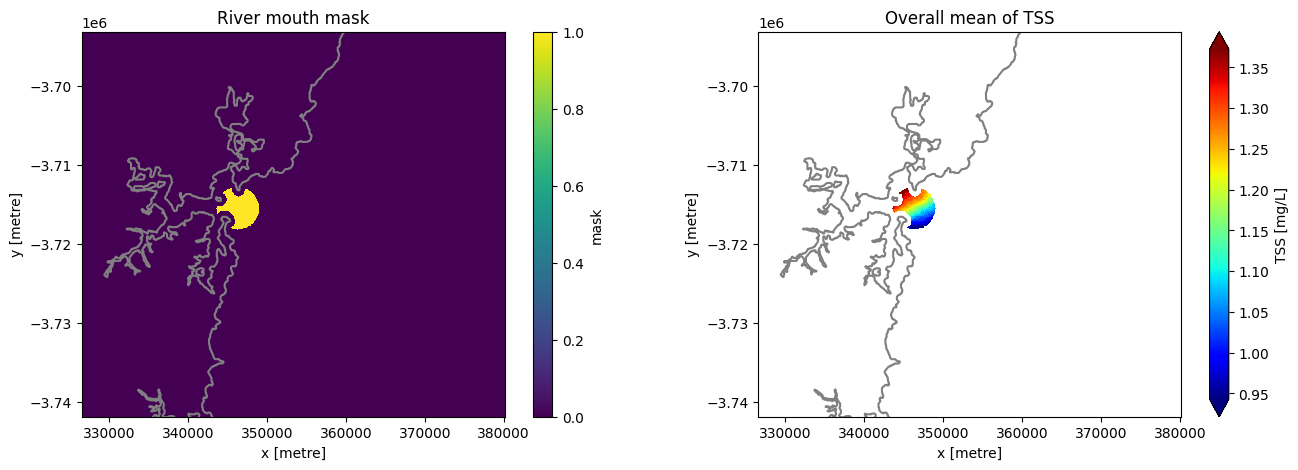

In [20]:
### Plots
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,5))

mask.plot(ax=ax1, cbar_kwargs={'label':'mask'})
shp_poly.boundary.plot(ax=ax1, color='grey')
ax1.set_title(f"River mouth mask")
ax1.set_aspect('equal','box')

### Example plot for selected param
data_msk.mean('time').plot(robust=True, cmap=cmap, cbar_kwargs={'label':f'{WQparam} [{WQunits}]'}, ax=ax2)   #, norm=norm)
shp_poly.boundary.plot(ax=ax2, color='grey')
ax2.set_title(f"Overall mean of {WQparam}")
ax2.set_aspect('equal','box')

## Spatial TSS statistics at river mouth

Quarterly median & IQR, min & max of the WQ parameter: here we derive the statistics of interest over all valid pixels spatially (within AOI), and temporally within quarters.


In [21]:
data_msk = data_msk.chunk({'x':128,'y':128})
data_msk = data_msk.dropna('time',how='all').persist()  # remove empty time slices
_ = wait(data_msk)

In [22]:
def qntle_fcn(ds, qnt):
    tmp = ds.chunk({'x':-1, 'y':-1, 'time':-1}).quantile(q=qnt, dim=['x','y','time'])
    return tmp

In [23]:
### Min, max, median + IQR calculations
WQlow_quart = data_msk.resample(time="QS",skipna=True).map(qntle_fcn,qnt=0.25).persist()
WQupp_quart = data_msk.resample(time="QS",skipna=True).map(qntle_fcn,qnt=0.75).persist()
WQmed_quart = data_msk.resample(time="QS",skipna=True).map(qntle_fcn,qnt=0.5).persist()
WQmin_quart = data_msk.resample(time="QS",skipna=True).min().min(['x','y']).persist()
WQmax_quart = data_msk.resample(time="QS",skipna=True).max().max(['x','y']).persist()
_ = wait(WQmax_quart)

/env/lib/python3.10/site-packages/dask/array/reductions.py:620: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/env/lib/python3.10/site-packages/dask/array/reductions.py:620: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/env/lib/python3.10/site-packages/dask/array/reductions.py:620: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/env/lib/python3.10/site-packages/dask/array/reductions.py:620: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/env/lib/python3.10/site-packages/dask/array/reductions.py:620: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/env/lib/python3.10/site-packages/dask/array/reductions.py:620: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/env/lib/python3

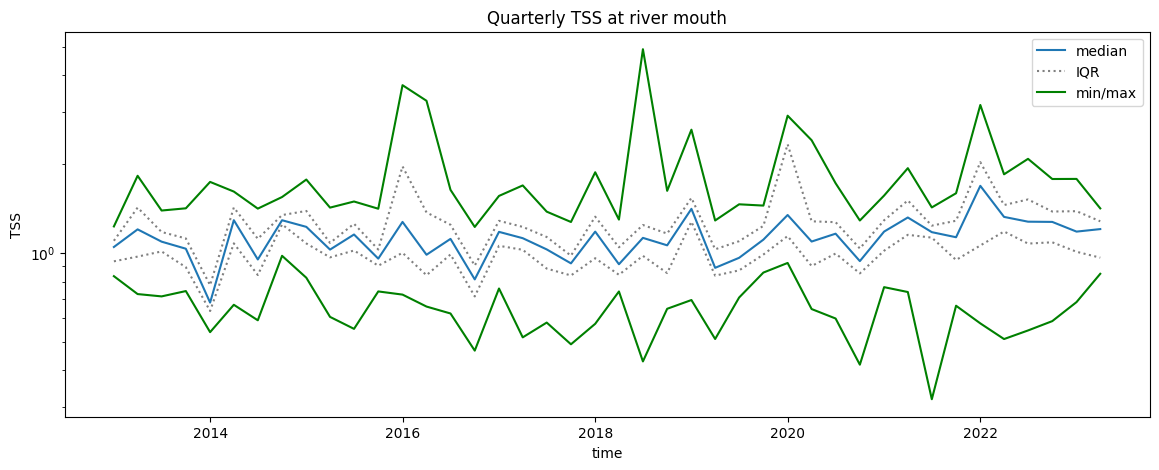

In [24]:
plt.figure(figsize=(14,5))
plt.plot(WQmed_quart.time, WQmed_quart, label='median')
plt.gca().plot(WQlow_quart.time, WQlow_quart,color='grey', ls=':', label='IQR')
plt.gca().plot(WQupp_quart.time, WQupp_quart,color='grey', ls=':')
plt.gca().plot(WQmin_quart.time, WQmin_quart,color='green', label='min/max')
plt.gca().plot(WQmax_quart.time, WQmax_quart,color='green')
plt.gca().set_yscale('log'); plt.gca().legend(); plt.gca().set_title(f'Quarterly TSS at river mouth')
plt.gca().set_xlabel('time'); plt.gca().set_ylabel('TSS')
plt.show()

## Load catchment shape file

We need the boundaries of each catchment of interest for the purpose of deriving the catchments' rainfall discharge.


In [25]:
buf_deg = 0.1   # lat/lon buffer around catchment (mainly for visualisation)
sname_list = [['hawkesbury','cowan','pittwater','brisbane']]   # sub-catchments corresponding to the above river systems (search names in catchment shape file)

In [26]:
### Load MAIN catchment shape file, extract desired polygons
shp_file = "./ancillary_data/EstCatch/EstEdit2.shp"   # MAIN catchments

catch_shp_list = []
for sname in sname_list:
    shp = gpd.read_file( shp_file ).to_crs('epsg:4326')

    drop_list = []
    for ff in shp.iterrows():
        tmp = ff[1].CATCHMENTN
        foo = [sn in tmp.lower() for sn in sname if tmp is not None]
        if not any(foo): drop_list.append( ff[0] )

    shp.drop( drop_list, inplace=True )   # remove polygons
    catch_shp_list.append(shp)

In [27]:
### Extract selected catchment's bounding box
bbox_list = []

for shp in catch_shp_list:
    tmp = shp.bounds   # DataFrame with columns minx, miny, maxx, maxy values containing the bounds for each geometry
    xmin = min(tmp.minx)
    xmax = max(tmp.maxx)
    ymin = min(tmp.miny)
    ymax = max(tmp.maxy)

    bbox = (xmin-buf_deg, ymin-buf_deg, xmax+buf_deg, ymax+buf_deg)   # polygon boundary
    bbox_list.append(bbox)

In [28]:
land_mask2, shp_poly2 = get_coastline( ds_lon_vec=[bbox[0],bbox[2]], ds_lat_vec=[bbox[1],bbox[3]], offset=offset)

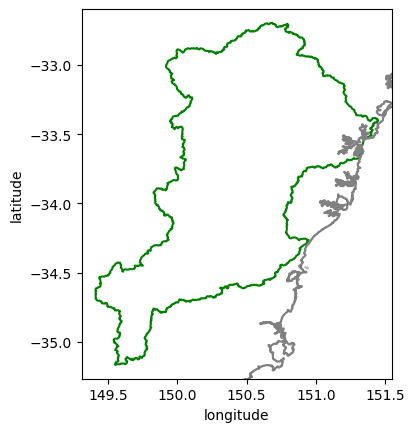

In [29]:
### Plots
for ii,catch in enumerate(catch_shp_list):
    bbox = bbox_list[ii]
    catch.boundary.plot(ax=plt.gca(), color='green')
    shp_poly2.boundary.plot(ax=plt.gca(), color='grey')
    plt.gca().set_xlim((bbox[0],bbox[2]))
    plt.gca().set_ylim((bbox[1],bbox[3]))
    plt.xlabel("longitude"); plt.ylabel("latitude")
    plt.show()

## BOM rainfall

Can access a variety of datasets hosted outside the current (ADIAS) EASI deployment:
  - DEA, e.g. fractional cover, landcover, etc.
  - IMOS, e.g. currents
  - Other EASI deployments, e.g. BoM rainfall, other satellite datasets, etc.
  - Raster and <i>in-situ</i> datasets
  - etc.

The BOM rainfall dataset used below can be accessed through the explorer's STAC API of the CSIRO EASI deployment (Sydney).

https://explorer.csiro.easi-eo.solutions/products/agcd_rain_recal_day -- DAY dataset  
https://explorer.csiro.easi-eo.solutions/products/agcd_rain_total_month -- MONTH dataset

In [30]:
bom_start_date = data_msk.time[0].values.astype(str)[:10]   
bom_end_date = data_msk.time[-1].values.astype(str)[:10]

In [31]:
%%time

time_chunk = 8

### Get the rainfall data:
catalog = pystac_client.Client.open("https://explorer.csiro.easi-eo.solutions/stac")

query = catalog.search( collections=['agcd_rain_total_month'], datetime=f"{bom_start_date}/{bom_end_date}", max_items=None )

rain_ds = odc.stac.load( query.items(), bbox=bbox, chunks={'longitude': 512, 'latitude': 512, 'time': time_chunk} ).persist()
_ = wait(rain_ds)

CPU times: user 1.29 s, sys: 74.2 ms, total: 1.36 s
Wall time: 8.12 s


BoM rainfall GeoTransform: [149.275 0.05 0.0 -32.575 0.0 -0.05]


<xarray.Dataset>
Dimensions:      (latitude: 54, longitude: 46, time: 121)
Coordinates:
  * latitude     (latitude) float64 -32.6 -32.65 -32.7 ... -35.15 -35.2 -35.25
  * longitude    (longitude) float64 149.3 149.4 149.4 ... 151.5 151.5 151.6
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2013-04-01 2013-05-01 ... 2023-04-01
Data variables:
    rain_total   (time, latitude, longitude) float32 dask.array<chunksize=(8, 54, 46), meta=np.ndarray>

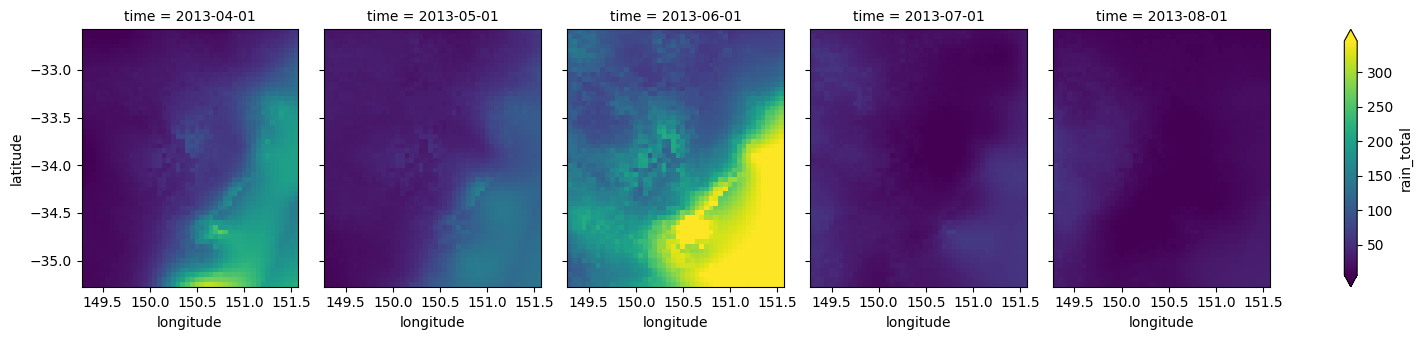

In [32]:
print(f'BoM rainfall GeoTransform: [{rain_ds.spatial_ref.GeoTransform}]')
display(rain_ds)
rain_ds.rain_total[:5].plot(figsize=(16,3.5), col='time', robust=True, col_wrap=5);

In [33]:
print( f"Rainfall dataset has {rain_ds.sizes['time']} time slices from {rain_ds.time[0].dt.date.values} to {rain_ds.time[-1].dt.date.values}." )
print( f"Rainfall {notebook_utils.xarray_object_size(rain_ds)}")

Rainfall dataset has 121 time slices from 2013-04-01 to 2023-04-01.
Rainfall Dataset size: 1.15 MB


## Catchment 'cookie-cutting'

In [34]:
### Create raster mask from catchment polygon
geotx = [float(vv) for vv in rain_ds.spatial_ref.GeoTransform.split()]
geotx = [geotx[1], geotx[2], geotx[0], geotx[4], geotx[5], geotx[3]]
aff = rasterio.Affine( *geotx )

mask = rasterio.features.rasterize( ((feat['geometry'], 1) for feat in catch.iterfeatures()),
                                    out_shape = (rain_ds.dims['latitude'],rain_ds.dims['longitude']),
                                    transform = aff )
mask = xr.DataArray(mask, coords=(rain_ds.latitude, rain_ds.longitude))

In [35]:
rain_ds = rain_ds.where(mask)   # cookie-cutting to catchment boundaries...

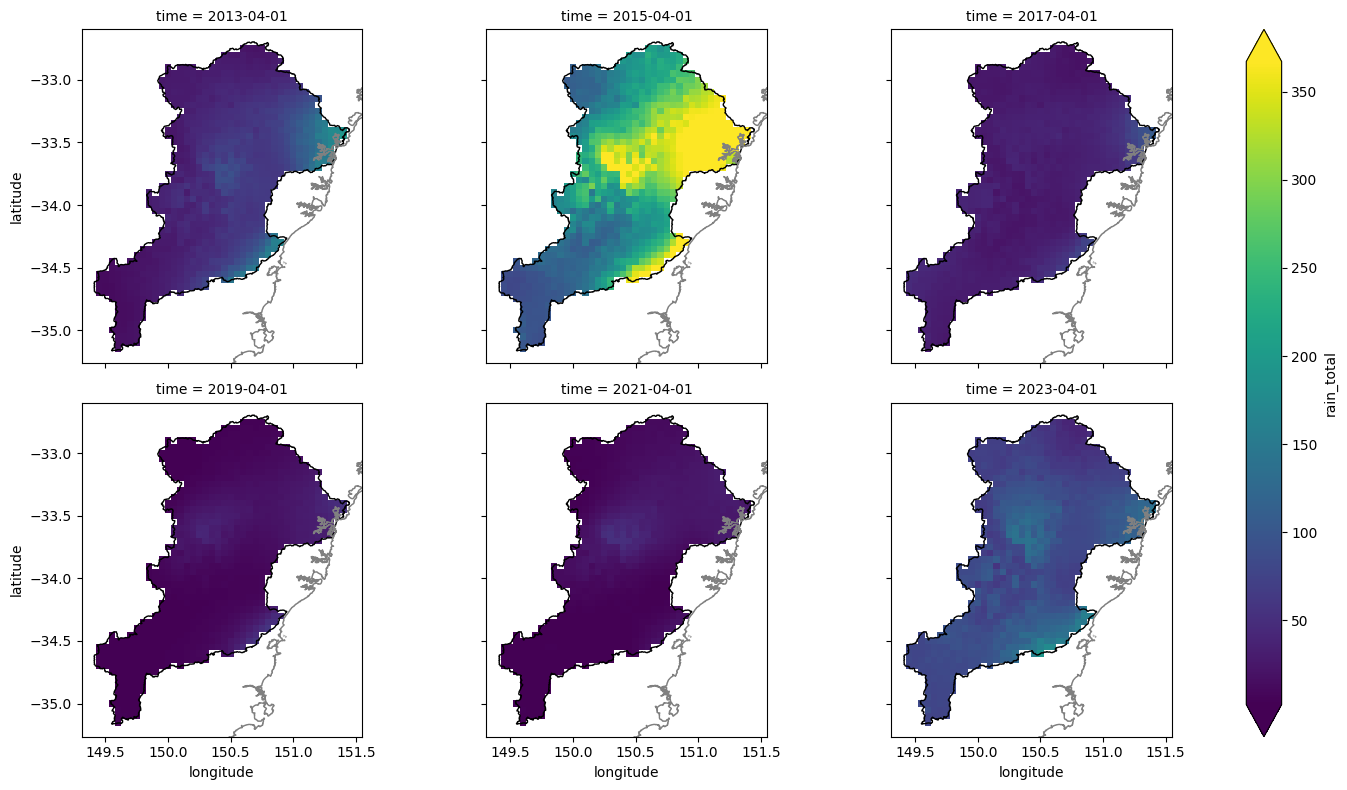

In [36]:
### Plot
tmp = np.linspace(1, rain_ds.sizes['time'], 6, dtype='int') - 1   # select a few time indices for plotting
pp = rain_ds.rain_total[tmp].plot(figsize=(16,8), col='time', robust=True, col_wrap = 3)

for ax in pp.axs.flat:
    catch.boundary.plot(ax=ax, color='black', linewidth=1)
    shp_poly2.boundary.plot(ax=ax, color='grey', linewidth=1)
    plt.gca().set_xlim((bbox[0],bbox[2]))
    plt.gca().set_ylim((bbox[1],bbox[3]))

## Catchment rainfall discharge & TSS flux

In [37]:
latlon_to_alb = pyproj.Transformer.from_crs("epsg:4326", "epsg:3577", always_xy=True)   # transform to equal-area Albers

def PolyArea(x,y):
    # Surface area of a polygon with 'x' and 'y' coordinates (vertices).
    # https://en.wikipedia.org/wiki/Shoelace_formula
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

pix_areas = mask.copy(deep=True).astype(float)
xres = abs(pix_areas.rio.resolution()[0])
yres = abs(pix_areas.rio.resolution()[1])

### Pix area in m^2 for each pixel
# Note: 0.05 x 0.05 deg pixel located at a latitude of about 23 degrees is about 26,832,000 square meters...
for lonind,latind in itertools.product(range(pix_areas.sizes['longitude']), range(pix_areas.sizes['latitude'])):
    if pix_areas[latind,lonind]==0: 
        pix_areas[latind,lonind] = np.nan
        continue    

    xmin = pix_areas.longitude[lonind].values
    xmax = xmin + xres
    ymin = pix_areas.latitude[latind].values
    ymax = ymin + yres

    pxvec, pyvec = latlon_to_alb.transform([xmin, xmin, xmax, xmax],[ymin, ymax, ymax, ymin])
    pix_areas[latind,lonind] = PolyArea(pxvec,pyvec)

In [38]:
assert WQunits=='mg/L', "Code below cannot handle selected WQ units."

### Selected flux units
mg_per_XX = 1_000_000_000_000; flux_units = 'kt/quarter'          # mg_per_kt
# mg_per_XX = 1_000_000_000_000_000; flux_units = 'Mt/quarter'      # mg_per_Mt
# mg_per_XX = 1_000_000_000_000_000_000; flux_units = 'Gt/quarter'  # mg_per_Gt

### Spatial & temporal (quarterly) aggregation of catchment rainfall ---> total catchment discharge volume in L (in each quarter)
### Apply pix area to rainfall data --> catchment rainfall runoff (river runoff) in [L/mth]
disch_vol_quart = (0.6 * rain_ds * pix_areas).rain_total.resample(time="QS",skipna=True).sum().sum(['latitude','longitude'])
assert np.all(WQmed_quart[1:].time.values==disch_vol_quart.time.values), f"Different TS dates."

### Flux
flux_low_quart = WQlow_quart[1:] * disch_vol_quart / mg_per_XX   # mg/L * L * Mt/mg
flux_upp_quart = WQupp_quart[1:] * disch_vol_quart / mg_per_XX
flux_med_quart = WQmed_quart[1:] * disch_vol_quart / mg_per_XX
flux_min_quart = WQmin_quart[1:] * disch_vol_quart / mg_per_XX
flux_max_quart = WQmax_quart[1:] * disch_vol_quart / mg_per_XX

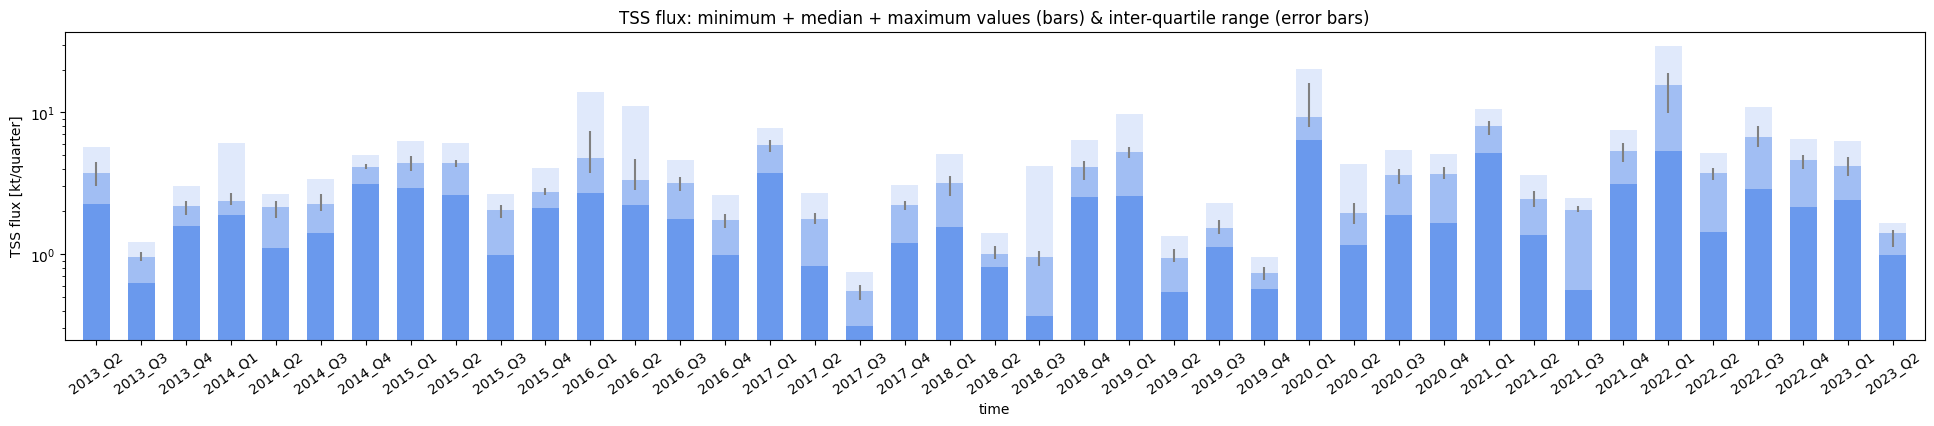

In [39]:
fig = plt.subplots(figsize=(24,4))
cols = 'cornflowerblue'   # ['yellowgreen','orange','cornflowerblue']
bw = 0.6   # bar width

fqlo = flux_low_quart.values
fqup = flux_upp_quart.values
fmed = flux_med_quart.values
fmin = flux_min_quart.values
fmax = flux_max_quart.values

yr = [str(tt) for tt in flux_low_quart.time.dt.year.values]
qr = [str(tt) for tt in flux_low_quart.time.dt.quarter.values]
tlab = [yy+'_Q'+qq for (yy,qq) in zip(yr,qr)]
tvec = np.arange(len(tlab))

plt.bar(tvec, fmax, color=cols, width=bw, alpha=0.2)
plt.bar(tvec, fmed, color=cols, width=bw, alpha=0.5, yerr=np.vstack((fmed-fqlo,fqup-fmed)), ecolor='grey')
plt.bar(tvec, fmin, color=cols, width=bw, alpha=0.9)
plt.gca().set_yscale('log')
plt.xticks(tvec, tlab, rotation=35)
plt.xlabel('time')
plt.ylabel(f'{WQparam} flux [{flux_units}]')
plt.margins(x=0.01)

plt.title(f'{WQparam} flux: minimum + median + maximum values (bars) & inter-quartile range (error bars)');

In [40]:
if n_workers is None:  # local Dask cluster
    cluster.close()
    client.shutdown()
else:   # Gateway cluster
    cluster.shutdown()
    client.close()    

In [41]:
### End notebook.